In [1]:
import pandas as pd
import torch
import evaluate
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from torch import nn

c:\Users\etgcr\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("PyTorch detecta CUDA:", torch.cuda.is_available())
print("Versão CUDA detectada pelo PyTorch:", torch.version.cuda)
print("Placa de vídeo em uso:", torch.cuda.get_device_name(0))

PyTorch detecta CUDA: True
Versão CUDA detectada pelo PyTorch: 12.6
Placa de vídeo em uso: NVIDIA GeForce GTX 1080


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Treinando modelo em: {device}")

🚀 Treinando modelo em: cuda


In [4]:
df = pd.read_csv("dataset_bibliografia.csv", delimiter=";")

In [5]:
label_map = {"nao_bibliografia": 0, "bibliografia": 1}
df["label"] = df["label"].map(label_map)

In [6]:
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
model_name = "neuralmind/bert-base-portuguese-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [8]:
def tokenize_function(examples):
    encoding = tokenizer(examples["texto"], padding="max_length", truncation=True, max_length=128)
    encoding["labels"] = examples["label"]  # ✅ Garante que "labels" está incluído
    return encoding

In [9]:
dataset = Dataset.from_pandas(df)
dataset = dataset.map(tokenize_function, batched=True)

dataset = dataset.remove_columns(["texto",])  # Remover colunas desnecessárias
dataset.set_format("torch")  # ✅ Garante que os dados estão no formato PyTorch

Map: 100%|██████████| 5000/5000 [00:02<00:00, 2445.15 examples/s]


In [10]:
train_test_split = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split["train"]
val_dataset = train_test_split["test"]

In [11]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)  # ✅ Enviar modelo para GPU

# 🔹 Adicionar Dropout no modelo (para evitar overfitting)
for param in model.bert.parameters():
    param.requires_grad = True  # Treinar todos os parâmetros do BERT
model.dropout = torch.nn.Dropout(p=0.3)  # ✅ Dropout maior para regularização

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# 🔹 Carregar métricas de avaliação
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# 🔹 Função para calcular métricas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # ✅ Garantir que logits e labels são arrays numpy
    if isinstance(logits, torch.Tensor):
        logits = logits.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()

    # 🔹 Obter previsões
    predictions = logits.argmax(axis=-1)

    # 🔹 Calcular métricas
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="macro")
    
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}


In [13]:
training_args = TrainingArguments(
    output_dir="./modelo_bibliografia",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,  # Ajuste de acordo com a VRAM
    per_device_eval_batch_size=8,  
    num_train_epochs=5,  # Treinar mais épocas para generalização
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",  # Evita logs desnecessários na nuvem
    fp16=True,  # ✅ Treino em FP16 para melhor desempenho
    warmup_ratio=0.1,  # ✅ Adiciona warmup para estabilidade
)

c:\Users\etgcr\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [15]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.053700,0.000065,1.000000,1.000000
2,0.000100,0.000023,1.000000,1.000000
3,0.000000,0.000014,1.000000,1.000000
4,0.000200,0.000011,1.000000,1.000000
5,0.000000,0.000010,1.000000,1.000000


In [16]:
results = trainer.evaluate()

In [17]:
model.save_pretrained("./modelo_bibliografia2")
tokenizer.save_pretrained("./modelo_bibliografia2")

('./modelo_bibliografia2\\tokenizer_config.json',
 './modelo_bibliografia2\\special_tokens_map.json',
 './modelo_bibliografia2\\vocab.txt',
 './modelo_bibliografia2\\added_tokens.json')

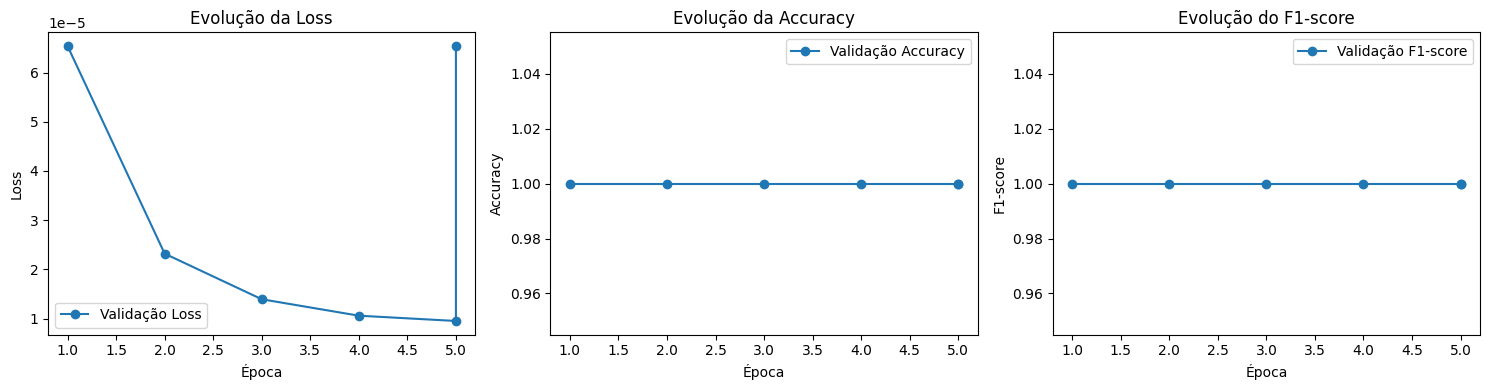

: 

In [ ]:
# Histórico completo
history = trainer.state.log_history

# Extrair métricas de treinamento e avaliação corretamente
epochs = [entry['epoch'] for entry in history if 'eval_loss' in entry]

train_loss = [entry['loss'] for entry in history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry]
eval_acc = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry]
eval_f1 = [entry['eval_f1'] for entry in history if 'eval_f1' in entry]

# Plot das métricas existentes (no seu caso, provavelmente só eval)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(epochs, eval_loss, marker='o', label='Validação Loss')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Evolução da Loss')
axes[0].legend()

# Accuracy
axes[1].plot(epochs, eval_acc, marker='o', label='Validação Accuracy')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Evolução da Accuracy')
axes[1].legend()

# F1-score
axes[2].plot(epochs, eval_f1, marker='o', label='Validação F1-score')
axes[2].set_xlabel('Época')
axes[2].set_ylabel('F1-score')
axes[2].set_title('Evolução do F1-score')
axes[2].legend()

plt.tight_layout()
plt.show()
